### Model Comparison
In this notebook we compare performance of four models
- Baseline model: Seasonal naive predictor
- RNN
- LSTM
- Transformer

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from importlib import reload
import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error
reload(functions)

<module 'functions' from 'c:\\Python64\\ADAML_GW\\adaml-ml-project\\functions.py'>

In [2]:
data_path = "household_power_consumption.txt"
df = functions.load_data(data_path)
df_hourly = functions.preprocess_data(df).reset_index()

In [3]:
#Add time variables: weekday, hour and day of year. Use sin/cosine transforms
df_hourly["hour_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.hour)/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.hour)/24)

df_hourly["weekday_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)
df_hourly["weekday_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)

df_hourly["day_of_year_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)
df_hourly["day_of_year_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)

In [4]:
#Dataset class for RNN, LSTM and Transformer
class EnergyData(Dataset):
    def __init__(self, features, targets, window,horizon):
        self.features = features
        self.targets = targets
        self.window = window
        self.horizon = horizon
        
    def __getitem__(self, index):
        x = self.features[index:index+self.window]
        y = self.targets[(index+self.window):(index+self.window+self.horizon)]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features) - self.window - self.horizon

Divide into training, validation and testing. As we are testing the proposed models, we use only training dataset to scale the testing data.

In [5]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year]
test_data = df_hourly.iloc[last_year:]


train_data,val_data = train_test_split(train_val_data,test_size=0.3,shuffle=False)

In [6]:
#Lookback window and horizon
window = 72
horizon = 24

batch_size = 128


Y_train = train_data["Global_active_power"].values
X_train = train_data.iloc[:, 1:len(train_data.columns)].values

X_test = test_data.iloc[:, 1:len(val_data.columns)].values
Y_test = test_data["Global_active_power"].values


scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

scalerX.fit(X_train)
scalerY.fit(Y_train.reshape(-1, 1))

test_X = scalerX.transform(X_test)
test_Y = scalerY.transform(Y_test.reshape(-1, 1))

#Dataset objects for models. We use lookback of 168 here as baseline model uses previous weeks observation
testData = EnergyData(test_X, test_Y, 7*24, horizon)



In [7]:
#Classes for models
class RNNForecastModel(nn.Module):
    def __init__(self, n_features, hidden_size, output_size, n_layers=2,device="cpu"):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device
        self.encoder = nn.RNN(n_features, hidden_size, n_layers, batch_first=True,nonlinearity="tanh",dropout=0.2) #Encoder
        self.decoder = nn.RNN(1,hidden_size,n_layers, batch_first=True,nonlinearity="tanh",dropout=0.2) #Decoder
        self.fc = nn.Linear(hidden_size, 1) # output layer
        
    def forward(self, X):
        #Encoding
        _, h = self.encoder(X)
        decoder_input = torch.zeros(X.size(0),1,1,device=self.device)
        outputs  = []
        for i in range(self.output_size):
            out, h = self.decoder(decoder_input,h)
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)
    

class Seq2SeqLSTM(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers,output_size):
        super().__init__()
        self.encoder = nn.LSTM(n_features,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.decoder = nn.LSTM(1,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.fc = nn.Linear(hidden_size,1)
        self.output_size = output_size
    def forward(self,X):
        # Encoding
        _, (h,c) = self.encoder(X)
        
        #Input for decoder
        decoder_input = torch.zeros(X.size(0),1,1,device=X.device)
        outputs = []

        for i in range(self.output_size):
            out, (h,c) = self.decoder(decoder_input, (h,c))
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)
    
#Credit https://www.ibm.com/think/topics/positional-encoding?
# & AI
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (B, S, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


#Credit: https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
class TransformerModel(nn.Module):
    def __init__(
        self,
        num_features,
        d_model=128,
        nhead=4,
        num_layers=3,
        dim_feedforward=128,
        max_len=5000,
        horizon=24,
        dropout=0.2,
    ):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, horizon)

    def forward(self, x):
        # x: (B, S, F)
        x = self.input_proj(x)      # (B, S, d_model)
        x = self.pos_encoder(x)     # (B, S, d_model)
        x = self.encoder(x)         # (B, S, d_model)

        # Average over time dimension
        x = x.mean(dim=1)           # (B, d_model)

        out = self.fc_out(x)        # (B, horizon)
        return out


In [ ]:
#Initialize neural network models
model_rnn = RNNForecastModel(n_features=13,hidden_size=32,output_size=24)
model_lstm = Seq2SeqLSTM(n_features=13,hidden_size=64,num_layers=2,output_size=24)
model_transformer = TransformerModel(num_features=13,horizon=24)

#Get weights
model_rnn.load_state_dict(torch.load("rnn_weights_finetuned.pth",weights_only=True,map_location="cpu"))
model_lstm.load_state_dict(torch.load("adaml_lstm_finetuned.pth",weights_only=True,map_location="cpu"))
model_transformer.load_state_dict(torch.load("adaml_transformer_finetuned.pth",weights_only=True,map_location="cpu"))

model_rnn.eval()
model_lstm.eval()
model_transformer.eval()


TransformerModel(
  (input_proj): Linear(in_features=13, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=24, bias=True)
)

### Samples from models

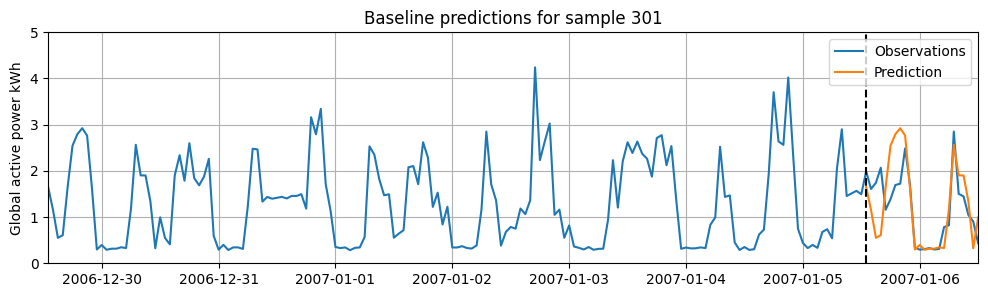

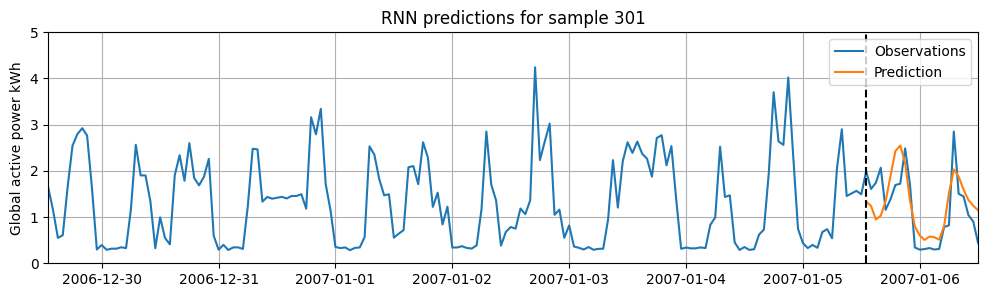

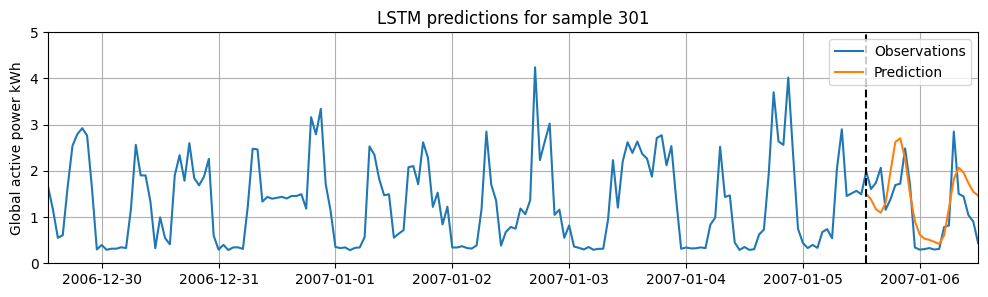

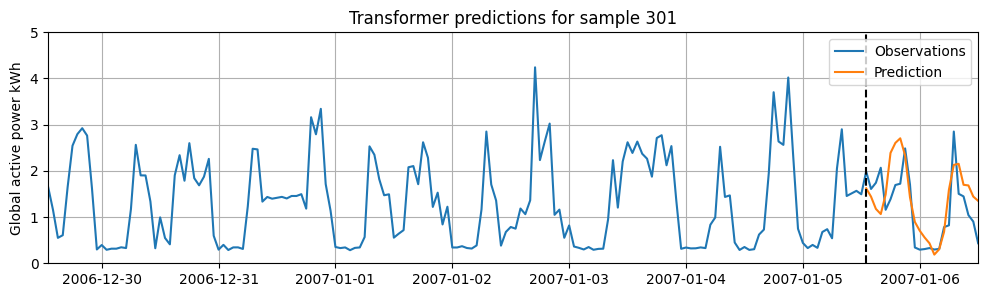

In [ ]:
index = 301 #Sample index
horizon = 24
lookback_rnn = 168
lookback_lstm = 120
lookback_transformer = 96

timestamps = df_hourly["datetime"].to_numpy()
#Timestamps for observations and after forecast
timestamps_observations = timestamps[(index):(index+168+horizon)]
timestamps_after_forecast = timestamps[(index+168):(index+168+horizon)]

X, y_actual = testData.__getitem__(index)
y_actual = scalerY.inverse_transform(y_actual)

#Observations before forecast
y_observations = np.concatenate((scalerY.inverse_transform(X[:,0].reshape(-1,1)),y_actual))
#Baseline model prediction
y_pred_baseline = scalerY.inverse_transform(X[:24,0].reshape(-1,1))

plt.figure(figsize=(12,3))
plt.plot(timestamps_observations,y_observations,label="Observations")
plt.plot(timestamps_after_forecast,y_pred_baseline,label="Prediction")
plt.xlim(timestamps_observations[0],timestamps_observations[168+horizon-1])
plt.vlines(timestamps_observations[168],0,5,linestyles="dashed",colors="black")
plt.ylabel("Global active power kWh")
plt.title(f"Baseline predictions for sample {index}")
plt.legend()
plt.ylim(0,5)
plt.grid()
plt.show()

with torch.no_grad():
    y_pred_rnn = model_rnn(X[-lookback_rnn:].unsqueeze(0)).numpy()[0]
    y_pred_rnn = scalerY.inverse_transform(y_pred_rnn)
plt.figure(figsize=(12,3))
plt.plot(timestamps_observations,y_observations,label="Observations")
plt.plot(timestamps_after_forecast,y_pred_rnn,label="Prediction")
plt.xlim(timestamps_observations[0],timestamps_observations[168+horizon-1])
plt.vlines(timestamps_observations[168],0,5,linestyles="dashed",colors="black")
plt.ylabel("Global active power kWh")
plt.title(f"RNN predictions for sample {index}")
plt.legend()
plt.ylim(0,5)
plt.grid()
plt.show()

with torch.no_grad():
    y_pred_lstm = model_lstm(X[-lookback_lstm:].unsqueeze(0)).numpy()[0]
    y_pred_lstm = scalerY.inverse_transform(y_pred_lstm)
plt.figure(figsize=(12,3))
plt.plot(timestamps_observations,y_observations,label="Observations")
plt.plot(timestamps_after_forecast,y_pred_lstm,label="Prediction")
plt.xlim(timestamps_observations[0],timestamps_observations[168+horizon-1])
plt.vlines(timestamps_observations[168],0,5,linestyles="dashed",colors="black")
plt.ylabel("Global active power kWh")
plt.title(f"LSTM predictions for sample {index}")
plt.legend()
plt.ylim(0,5)
plt.grid()
plt.show()


with torch.no_grad():
    y_pred_transformer = model_transformer(X[-lookback_transformer:].unsqueeze(0)).numpy()[0]
    y_pred_transformer = scalerY.inverse_transform(y_pred_transformer.reshape(-1,1))
plt.figure(figsize=(12,3))
plt.plot(timestamps_observations,y_observations,label="Observations")
plt.plot(timestamps_after_forecast,y_pred_transformer,label="Prediction")
plt.xlim(timestamps_observations[0],timestamps_observations[168+horizon-1])
plt.ylim(0,5)
plt.vlines(timestamps_observations[168],0,5,linestyles="dashed",colors="black")
plt.ylabel("Global active power kWh")
plt.title(f"Transformer predictions for sample {index}")
plt.legend()
plt.grid()
plt.show()


### RMSE and MAAPE values for the dataset

In [16]:
#Arrays for RMSE-values
rmse_baseline = []
rmse_rnn = []
rmse_lstm = []
rmse_transformer = []

#Arrays for MAAPE-values
maape_baseline = []
maape_rnn = []
maape_lstm = []
maape_transformer = []

for index in range(testData.__len__()):
    X, y_actual = testData.__getitem__(index)
    y_actual = scalerY.inverse_transform(y_actual)

    #Baseline model prediction
    y_pred_baseline = scalerY.inverse_transform(X[:24,0].reshape(-1,1))
    rmse_baseline.append(root_mean_squared_error(y_actual,y_pred_baseline))
    maape_baseline.append(functions.mean_arctangent_absolute_percentage_error(y_actual,y_pred_baseline))


    with torch.no_grad():
        #RNN
        y_pred_rnn = model_rnn(X[-lookback:].unsqueeze(0)).numpy()[0]
        y_pred_rnn = scalerY.inverse_transform(y_pred_rnn)
        rmse_rnn.append(root_mean_squared_error(y_actual,y_pred_rnn))
        maape_rnn.append(functions.mean_arctangent_absolute_percentage_error(y_actual,y_pred_rnn))

        #LSTM
        y_pred_lstm = model_lstm(X[-lookback:].unsqueeze(0)).numpy()[0]
        y_pred_lstm = scalerY.inverse_transform(y_pred_lstm)
        rmse_lstm.append(root_mean_squared_error(y_actual,y_pred_lstm))
        maape_lstm.append(functions.mean_arctangent_absolute_percentage_error(y_actual,y_pred_lstm))

        #Transformer
        y_pred_transformer = model_transformer(X[-lookback:].unsqueeze(0)).numpy()[0]
        y_pred_transformer = scalerY.inverse_transform(y_pred_transformer.reshape(-1,1))
        rmse_transformer.append(root_mean_squared_error(y_actual,y_pred_transformer))
        maape_transformer.append(functions.mean_arctangent_absolute_percentage_error(y_actual,y_pred_transformer)) 

rmse_values = [rmse_baseline,rmse_rnn,rmse_lstm,rmse_transformer]
maape_values = [maape_baseline,maape_rnn,maape_lstm,maape_transformer]


In [17]:
print(f"RMSE means: {np.mean(rmse_values,axis=1)}")
print(f"MAAPE means: {np.mean(maape_values,axis=1)}")

RMSE means: [0.77723512 0.60393269 0.60905482 0.60766894]
MAAPE means: [0.44655692 0.44345211 0.44952312 0.45335163]


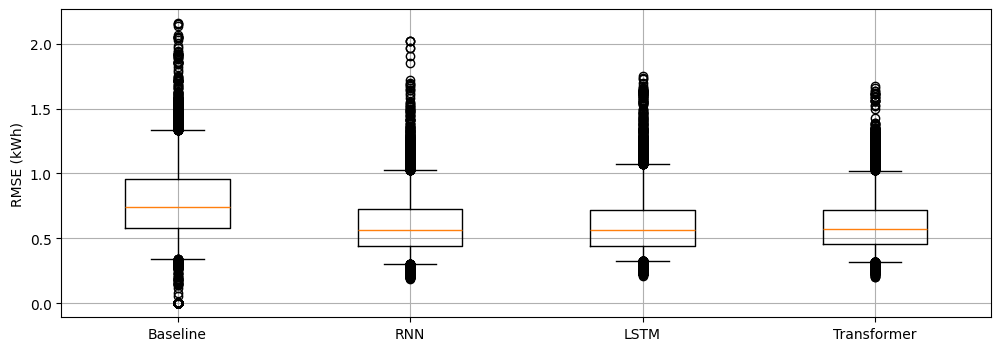

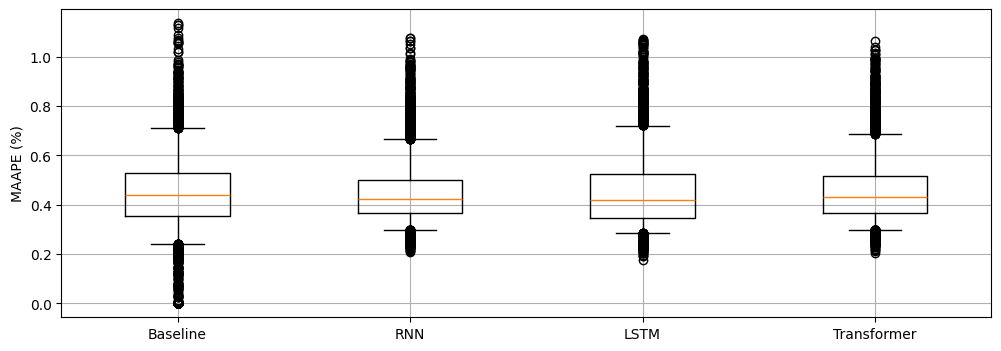

In [18]:
plt.figure(figsize=(12,4))
plt.boxplot(rmse_values,labels=["Baseline","RNN","LSTM","Transformer"],whis=[5,95])
plt.grid()
plt.ylabel("RMSE (kWh)")
plt.show()

plt.figure(figsize=(12,4))
plt.boxplot(maape_values,labels=["Baseline","RNN","LSTM","Transformer"],whis=[5,95])
plt.grid()
plt.ylabel("MAAPE (%)")
plt.show()